In [1]:
import random
from collections import Counter
from multiprocessing import Pool, cpu_count
from typing import Dict, List, Set, Tuple

import networkx as nx
import numpy as np
import pandas as pd

from icm_diffusion import simulate_diffusion_ICM
from src.graph import (
    create_polarized_graph,
    graph_loader,
    random_color_graph,
    spectral_bipartition_coloring,
    spectral_partition_coloring,
)
from src.seed import seed_degree, seed_mia, seed_polarized, seed_random


In [2]:
from edge_addition import (
    edge_addition_custom,
    edge_addition_adamic_adar,
    edge_addition_preferential_attachment,
    edge_addition_jaccard,
    edge_addition_degree,
    edge_addition_topk,
    edge_addition_prob,
    edge_addition_kkt,
    edge_addition_random,
)

In [3]:
# Function to evaluate and compare the graph modifications
def evaluate_graph_modifications(G, seeds, k, max_iter, budget):
    # Simulate diffusion on the original graph
    count, count_std, color_count, color_count_std = simulate_diffusion_ICM(
        G, seeds, max_iter
    )

    # Results for the original graph
    original_results = pd.DataFrame(
        {
            "Metric": [
                "Count",
                "Count Standard Deviation",
                "Color Count",
                "Color Count Standard Deviation",
            ],
            "Original Graph": [
                round(count, 3),
                round(count_std, 3),
                round(color_count, 3),
                round(color_count_std, 3),
            ],
        }
    )

    # Get the number of nodes and edges for all graphs
    graph_info = {
        "Metric": ["Number of Nodes", "Number of Edges"],
        "Original Graph": [G.number_of_nodes(), G.number_of_edges()],
    }
    #'Adamic Adar': edge_addition_adamic_adar,
    # Define a list of modification functions
    modification_functions = {
        "PrefAtt": edge_addition_preferential_attachment,
        "Jaccard": edge_addition_jaccard,
        "Degree": edge_addition_degree,
        "TopK": edge_addition_topk,
        "Prob": edge_addition_prob,
        "KKT": edge_addition_kkt,
        "Random": edge_addition_random,
        "Custom": edge_addition_custom,
    }

    combined_results = original_results.copy()

    # Evaluate each graph modification
    for method_name, mod_func in modification_functions.items():
        modified_graph = mod_func(G, seeds, k, budget)
        count, count_std, color_count, color_count_std = simulate_diffusion_ICM(
            modified_graph, seeds, max_iter
        )

        adapted_results = pd.DataFrame(
            {
                "Metric": [
                    "Count",
                    "Count Standard Deviation",
                    "Color Count",
                    "Color Count Standard Deviation",
                ],
                f"Adapted Graph {method_name}": [
                    round(count, 3),
                    round(count_std, 3),
                    round(color_count, 3),
                    round(color_count_std, 3),
                ],
            }
        )

        combined_results = pd.merge(combined_results, adapted_results, on="Metric")
        graph_info[f"Adapted Graph {method_name}"] = [
            modified_graph.number_of_nodes(),
            modified_graph.number_of_edges(),
        ]

    graph_info_df = pd.DataFrame(graph_info)

    # Combine all results into one DataFrame
    final_results = pd.concat([graph_info_df, combined_results], ignore_index=True)

    # Transpose the DataFrame and set the first row as the header
    final_results = final_results.T
    final_results.columns = final_results.iloc[
        0
    ]  # Set the first row as the column names
    final_results = final_results.drop(final_results.index[0])  # Drop the first row

    return final_results


In [4]:
#G = create_polarized_graph(1000, 0.2, 0.01)
G= graph_loader("datasets/facebook/facebook_combined.txt")
#G = graph_loader('datasets/congress_network/congress.edgelist')
#color the graph
spectral_bipartition_coloring(G)
color_map = ['blue' if G.nodes[node]["color"] == 1 else 'red' for node in G.nodes()]
print(Counter(color_map))

Number of Nodes: 4039
Number of Edges: 88234


In [6]:
seed = seed_mia(G, 100)
k = 100
max_iter = 1000
budget = 3 * len(seed)
final_results = evaluate_graph_modifications(G, seed, k, max_iter, budget)
final_results

100%|██████████| 1000/1000 [00:22<00:00, 43.65it/s]


Metric,Number of Nodes,Number of Edges,Count,Count Standard Deviation,Color Count,Color Count Standard Deviation
Original Graph,4039.0,88234.0,3112.109,152.116,478.644,49.715
Adapted Graph PrefAtt,4039.0,88534.0,3117.141,154.209,484.082,48.617
Adapted Graph Jaccard,4039.0,88534.0,3136.46,155.935,499.48,49.474
Adapted Graph Degree,4039.0,88534.0,3170.587,134.446,518.774,58.226
Adapted Graph TopK,4039.0,88534.0,3108.34,158.178,477.602,49.464
Adapted Graph Prob,4039.0,88534.0,3187.896,148.862,518.454,53.982
Adapted Graph KKT,4039.0,88534.0,3160.496,138.567,486.183,49.434
Adapted Graph Random,4039.0,88534.0,3149.542,160.067,508.824,54.364
Adapted Graph Custom,4039.0,88534.0,3266.792,115.987,675.563,73.359


In [7]:
seed = seed_polarized(G, 100, 0)
k = 100
max_iter = 1000
budget = 3 * len(seed)
final_results = evaluate_graph_modifications(G, seed, k, max_iter, budget)
final_results

100%|██████████| 1000/1000 [00:44<00:00, 22.32it/s]


Metric,Number of Nodes,Number of Edges,Count,Count Standard Deviation,Color Count,Color Count Standard Deviation
Original Graph,4039.0,88234.0,616.396,139.706,64.195,25.639
Adapted Graph PrefAtt,4039.0,88534.0,1731.578,571.552,230.873,151.297
Adapted Graph Jaccard,4039.0,88534.0,1137.41,169.546,119.332,51.381
Adapted Graph Degree,4039.0,88534.0,2928.3,144.645,764.939,187.753
Adapted Graph TopK,4039.0,88534.0,621.37,141.021,64.82,25.648
Adapted Graph Prob,4039.0,88534.0,1421.732,265.889,234.259,70.67
Adapted Graph KKT,4039.0,88534.0,2635.607,179.807,459.685,130.422
Adapted Graph Random,4039.0,88534.0,889.557,181.635,129.671,57.825
Adapted Graph Custom,4039.0,88534.0,2533.701,176.607,718.237,276.572


In [8]:
seed = seed_random(G, 100)
k = 100
max_iter = 1000
budget = 3 * len(seed)
final_results = evaluate_graph_modifications(G, seed, k, max_iter, budget)
final_results

100%|██████████| 1000/1000 [00:49<00:00, 20.12it/s]


Metric,Number of Nodes,Number of Edges,Count,Count Standard Deviation,Color Count,Color Count Standard Deviation
Original Graph,4039.0,88234.0,654.315,289.255,68.064,100.794
Adapted Graph PrefAtt,4039.0,88534.0,2541.504,208.582,631.182,220.753
Adapted Graph Jaccard,4039.0,88534.0,1178.853,351.884,156.199,83.552
Adapted Graph Degree,4039.0,88534.0,2837.429,168.289,723.908,169.402
Adapted Graph TopK,4039.0,88534.0,658.23,286.944,67.382,89.029
Adapted Graph Prob,4039.0,88534.0,1325.401,289.056,172.356,101.276
Adapted Graph KKT,4039.0,88534.0,2601.017,214.88,682.197,266.434
Adapted Graph Random,4039.0,88534.0,817.376,312.384,93.873,97.918
Adapted Graph Custom,4039.0,88534.0,2454.207,221.789,888.108,342.823


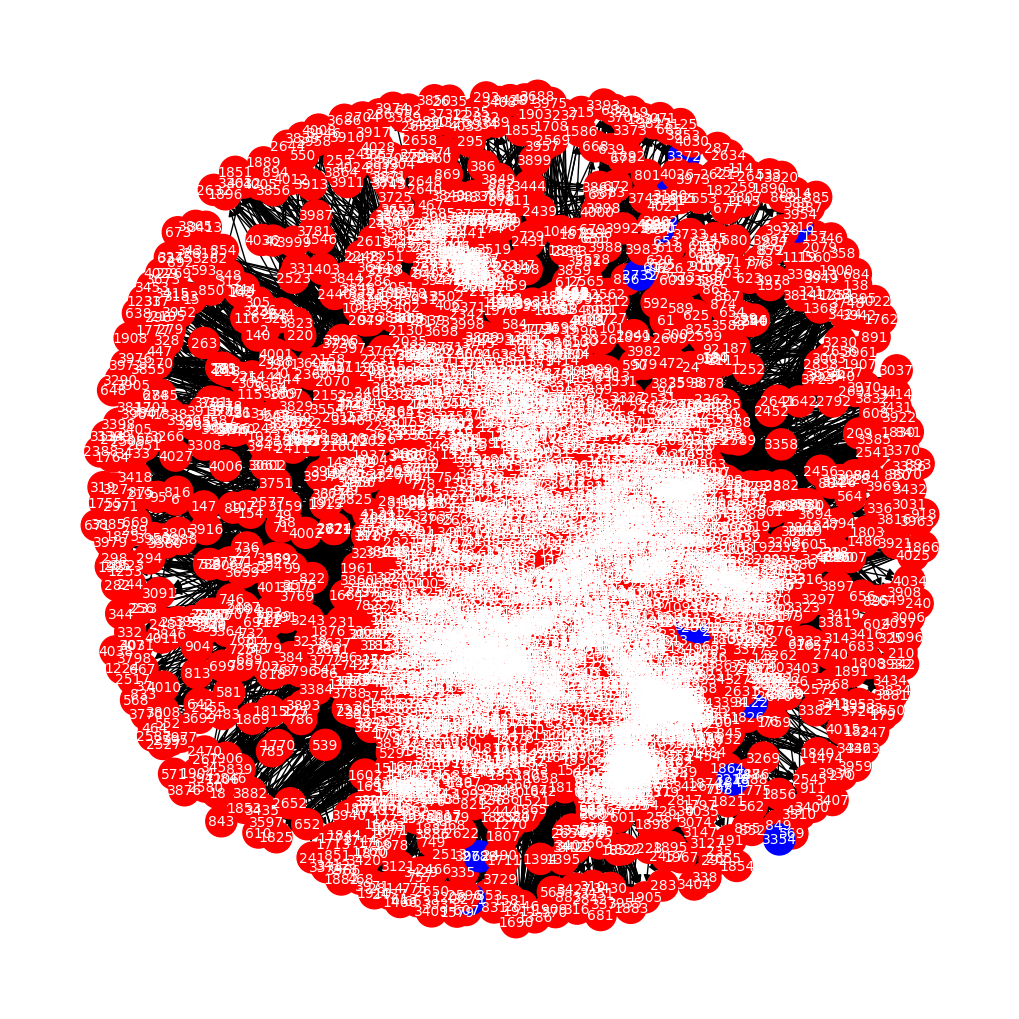

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_colored_graph(G):
    # Get colors for each node based on the 'color' attribute
    color_map = ['blue' if G.nodes[node]["color"] == 1 else 'red' for node in G.nodes()]
    
    # Draw the graph
    plt.figure(figsize=(10, 10))
    nx.draw(G, node_color=color_map, with_labels=True, node_size=500, font_color='white', font_size=10)
    
    # Display the graph
    plt.show()

draw_colored_graph(G)